<a href="https://colab.research.google.com/github/Monaa48/TensorFlow-in-Action-starter/blob/main/notebooks/Ch07_Teaching_machines_to_see_better_Improving_CNNs_and_making_them_confess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 07 — Teaching Machines to See Better: Improving CNNs and Making Them Confess

In Chapter 6, the main focus was building a working CNN-based classifier pipeline on **Tiny ImageNet** and reproducing an Inception-like model.  
In this chapter, I continue from that point and try to answer two practical questions that come up immediately when training CNNs on real images:

1) **How do I reduce overfitting and improve generalization?**  
2) **How can I inspect what a CNN is focusing on, instead of treating it as a black box?**

To keep the work reproducible in Colab, I keep the dataset download + directory structure explicit, build a clear train/validation/test pipeline, and then incrementally add improvements:
- stronger data augmentation (including custom augmentations that are not built-in),
- dropout in the right places,
- a more modern “minimal Inception” style model,
- transfer learning with a pretrained network,
- Grad-CAM for model interpretability.


## 1) Summary

This chapter is essentially about moving from “a CNN that trains” to “a CNN that generalizes and can be inspected.”

### 1.1 Why overfitting becomes a problem here
Tiny ImageNet is closer to real-world vision than MNIST/CIFAR-10:
- Images are small (64×64) but contain clutter and background.
- There are **200 classes**, which increases the decision complexity.
- Many classes are visually similar (fine-grained categories), and the model can easily memorize patterns that do not transfer.

When a model overfits, training accuracy can keep improving while validation accuracy stagnates or worsens.  
So the core idea is to apply techniques that encourage the model to learn features that remain useful on unseen images.

### 1.2 Techniques used in this notebook
I reproduce and combine multiple techniques described in the chapter:

**A) Data augmentation (built-in options)**  
Using Keras `ImageDataGenerator`, I apply transformations such as:
- rotations, shifts, zoom, and shearing,
- horizontal flips,
- a fill mode that avoids unnatural borders (e.g., `reflect`).

These changes produce “new” versions of training images, which forces the model to become robust to nuisance factors.

**B) Custom augmentations (not built-in)**
Two augmentations in this chapter are implemented manually:
- **Gamma correction**: raises normalized pixels to a random power (helps exposure/illumination variation).
- **Random occlusion**: covers a random patch with a constant color (helps robustness when objects are partially blocked).

In addition, I do the per-image centering step explicitly in the custom generator (because in the chapter, the built-in `samplewise_center` is disabled temporarily to allow custom preprocessing first).

**C) Dropout as regularization**
Dropout helps reduce reliance on a single set of “spiky” features.
In the chapter’s setup, dropout is applied mainly:
- inside auxiliary heads (high dropout, e.g., 0.7),
- and before the final classifier (moderate dropout, e.g., 0.4),
which is consistent with the intuition that dense layers tend to overfit more than early convolution layers.

**D) A more compact architecture: Minception**
The chapter then introduces a more modern, “minimal” Inception-style model that uses:
- multi-branch computation (different receptive fields),
- residual-style connections,
- and a reduction block for downsampling.
The aim is to preserve the advantages of Inception while keeping the model simpler than early Inception variants.

**E) Transfer learning**
Instead of training everything from scratch, a pretrained model (trained on ImageNet) can provide strong generic visual features.
I reproduce a practical transfer learning workflow:
- start with a pretrained backbone (e.g., Inception-ResNet v2),
- attach a new classification head for 200 classes,
- train the head first (freeze the backbone),
- optionally fine-tune a few top layers later.

**F) Grad-CAM for interpretability**
Finally, I implement Grad-CAM to visualize which spatial regions contribute most to a prediction:
- pick a convolution layer near the end of the network,
- compute gradients of the target class score w.r.t. feature maps,
- combine them into a heatmap and overlay it on the image.
This produces a concrete “where the model is looking” diagnostic, which is useful for debugging dataset issues and model behavior.

### 1.3 What I expect from outputs
Because Tiny ImageNet is large, full training can take time in Colab.  
So the notebook is structured so that:
- the pipeline (data + model + training loop) runs end-to-end,
- training can be scaled by adjusting epochs and steps,
- evaluation is always done on a fixed validation/test generator (no augmentation),
- Grad-CAM works with the trained model or even with a pretrained model fine-tuned for a few iterations.


## 2) Setup

Imports, reproducibility seeds, and a few global constants.

In [1]:
import os
import random
import zipfile
import urllib.request
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt

SEED = 4321
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


## 3) Download and unpack Tiny ImageNet

The dataset used in this chapter is **Tiny ImageNet-200**, commonly distributed as a zip file:
- `http://cs231n.stanford.edu/tiny-imagenet-200.zip`

Folder structure (after extraction):
- `train/<wnid>/images/*.JPEG`
- `val/images/*.JPEG`
- `val/val_annotations.txt` (maps validation filenames to wnids)
- `wnids.txt` and `words.txt` (class ids + readable names)


In [2]:
DATA_ROOT = Path("data")
DATA_ROOT.mkdir(parents=True, exist_ok=True)

url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
zip_path = DATA_ROOT / "tiny-imagenet-200.zip"
extract_dir = DATA_ROOT / "tiny-imagenet-200"

if not zip_path.exists():
    print("Downloading:", url)
    urllib.request.urlretrieve(url, zip_path)
    print("Saved to:", zip_path)

if not extract_dir.exists():
    print("Extracting zip...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(DATA_ROOT)
    print("Extracted to:", extract_dir)
else:
    print("Dataset folder already exists:", extract_dir)

train_dir = extract_dir / "train"
val_dir = extract_dir / "val"
print("Train dir:", train_dir)
print("Val dir  :", val_dir)


Downloading: http://cs231n.stanford.edu/tiny-imagenet-200.zip
Saved to: data/tiny-imagenet-200.zip
Extracting zip...
Extracted to: data/tiny-imagenet-200
Train dir: data/tiny-imagenet-200/train
Val dir  : data/tiny-imagenet-200/val


## 4) Exploratory analysis (dataset structure + sanity checks)

I keep this section short but practical:
- read class IDs and readable labels,
- verify training images per class,
- confirm the image size is 64×64,
- visualize a few images to understand the complexity.


In [3]:
wnids_path = extract_dir / "wnids.txt"
words_path = extract_dir / "words.txt"

def get_tiny_imagenet_classes(wnids_path, words_path):
    wnids = pd.read_csv(wnids_path, header=None)[0].astype(str)

    words = pd.read_csv(words_path, sep="\t", index_col=0, header=None)
    words = words[1].astype(str)

    labels = pd.DataFrame({"wnid": wnids})
    labels["class"] = labels["wnid"].map(words)
    return labels

labels = get_tiny_imagenet_classes(wnids_path, words_path)
print("Number of classes:", len(labels))
labels.head()


Number of classes: 200


,wnid,class
0,n02124075,Egyptian cat
1,n04067472,reel
2,n04540053,volleyball
3,n04099969,"rocking chair, rocker"
4,n07749582,lemon


In [4]:
def count_jpegs(p: Path):
    if not p.exists():
        return 0
    return len([f for f in os.listdir(p) if f.lower().endswith("jpeg")])

labels["n_train"] = labels["wnid"].apply(lambda w: count_jpegs(train_dir / w / "images"))
labels["n_train"].describe()


,n_train
count,200.0
mean,500.0
std,0.0
min,500.0
25%,500.0
50%,500.0
75%,500.0
max,500.0


In [5]:
# Check image sizes on a small subset
sizes = []
for wnid in labels["wnid"].iloc[:20]:
    img_dir = train_dir / wnid / "images"
    files = [f for f in os.listdir(img_dir) if f.endswith("JPEG")][:10]
    for f in files:
        sizes.append(Image.open(img_dir / f).size)

pd.DataFrame(sizes, columns=["width", "height"]).describe()


,width,height
count,200.0,200.0
mean,64.0,64.0
std,0.0,0.0
min,64.0,64.0
25%,64.0,64.0
50%,64.0,64.0
75%,64.0,64.0
max,64.0,64.0


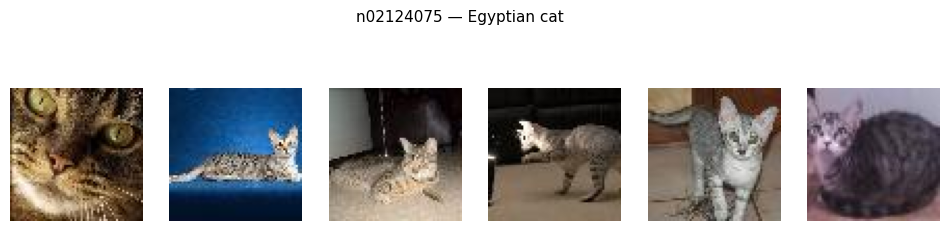

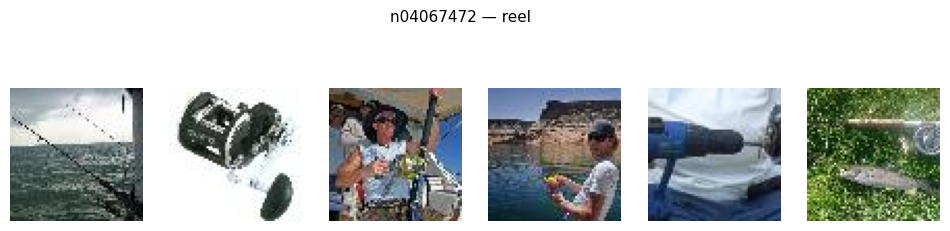

In [6]:
def show_samples_for_wnid(wnid, n=6):
    img_dir = train_dir / wnid / "images"
    files = [f for f in os.listdir(img_dir) if f.endswith("JPEG")][:n]
    desc = labels.loc[labels["wnid"] == wnid, "class"].values[0]

    plt.figure(figsize=(12, 3))
    for i, f in enumerate(files):
        img = Image.open(img_dir / f)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"{wnid} — {desc}", fontsize=11)
    plt.show()

for wnid in labels["wnid"].iloc[:2]:
    show_samples_for_wnid(wnid, n=6)


## 5) Train/validation/test data generators

### 5.1 Why I separate train augmentation from validation/testing
Validation should reflect a stable, realistic distribution.  
So in this notebook:
- training data uses **augmentation**,
- validation and test data use **no augmentation**.

This keeps the validation signal consistent and makes training curves easier to interpret.

### 5.2 Notes about centering and custom preprocessing
In the chapter, `samplewise_center` is disabled in `ImageDataGenerator` so custom augmentations can be applied first.  
I reproduce the same approach:
- the base generator yields raw float images,
- the wrapper generator optionally applies gamma + occlusion,
- finally, it performs per-image centering and formats outputs for multi-output models.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
TARGET_SIZE = (64, 64)  # Tiny ImageNet native resolution

# Augment only the training generator
image_gen_aug = ImageDataGenerator(
    samplewise_center=False,  # done later in the wrapper generator
    validation_split=0.1,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="reflect",
)

# No augmentation for validation and test
image_gen_plain = ImageDataGenerator(
    samplewise_center=False,
    validation_split=0.1,
)

# Training subset (augmented)
train_gen = image_gen_aug.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset="training",
)

# Validation subset (NOT augmented)
valid_gen = image_gen_plain.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    subset="validation",
)

# Validation folder labels
val_annotations_path = val_dir / "val_annotations.txt"
test_df = pd.read_csv(val_annotations_path, sep="\t", header=None).iloc[:, [0, 1]]
test_df.columns = ["filename", "class"]

# Keep class order consistent with train_gen
class_list = list(train_gen.class_indices.keys())

test_gen = image_gen_plain.flow_from_dataframe(
    dataframe=test_df,
    directory=str(val_dir / "images"),
    x_col="filename",
    y_col="class",
    classes=class_list,
    target_size=TARGET_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
)

print("train samples:", train_gen.samples)
print("valid samples:", valid_gen.samples)
print("test  samples:", test_gen.samples)


Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
train samples: 90000
valid samples: 10000
test  samples: 10000


### 5.3 Wrapper generator: gamma correction, random occlusion, and output formatting

This wrapper does three practical things:
1) optional gamma correction (illumination robustness),
2) optional random occlusion (partial-visibility robustness),
3) per-image centering and formatting outputs for multi-output architectures.

In the chapter’s Inception v1 setup, the model has **three outputs** (main + 2 auxiliary),
so the generator returns `(x, (y, y, y))`.


In [8]:
def apply_random_gamma(x, gamma_range=(0.7, 1.5)):
    # x: float32 images in [0, 255] (typical ImageDataGenerator output)
    gamma = np.random.uniform(*gamma_range)
    x01 = np.clip(x / 255.0, 0.0, 1.0)
    x01 = np.power(x01, gamma)
    return (x01 * 255.0).astype(np.float32)

def apply_random_occlusion(x, occ_prob=0.5, occ_min=8, occ_max=24):
    # x: (batch, H, W, C)
    b, h, w, c = x.shape
    for i in range(b):
        if np.random.rand() > occ_prob:
            continue
        occ_h = np.random.randint(occ_min, occ_max + 1)
        occ_w = np.random.randint(occ_min, occ_max + 1)
        y0 = np.random.randint(0, max(1, h - occ_h))
        x0 = np.random.randint(0, max(1, w - occ_w))

        color = np.random.choice([0.0, 127.5, 255.0])
        x[i, y0:y0+occ_h, x0:x0+occ_w, :] = color
    return x

def data_gen_augmented_inception_v1(gen, random_gamma=False, random_occlude=False):
    while True:
        x, y = next(gen)

        # Custom augmentations (applied only if enabled)
        if random_gamma:
            x = apply_random_gamma(x)

        if random_occlude:
            x = apply_random_occlusion(x, occ_prob=0.5)

        # Per-image centering (mean subtraction per sample)
        x = x.astype(np.float32)
        x -= np.mean(x, axis=(1, 2, 3), keepdims=True)

        # Inception v1-style multi-output target format
        yield x, (y, y, y)

# Training uses extra augmentations; validation/test do not
train_gen_aux = data_gen_augmented_inception_v1(train_gen, random_gamma=True, random_occlude=True)
valid_gen_aux = data_gen_augmented_inception_v1(valid_gen)
test_gen_aux  = data_gen_augmented_inception_v1(test_gen)

# Sanity-check one batch
x0, (y0a, y0b, y0c) = next(train_gen_aux)
print("x:", x0.shape, x0.dtype, "mean (batch):", float(np.mean(x0)))
print("y:", y0a.shape, y0b.shape, y0c.shape)


x: (128, 64, 64, 3) float32 mean (batch): 6.159146437312302e-07
y: (128, 200) (128, 200) (128, 200)


## 6) Inception v1-style model with dropout improvements

In the chapter, dropout is reintroduced because it is part of the original Inception v1 design,
and it is especially helpful for dense layers that can overfit.

Changes reproduced here:
- auxiliary heads: add **Dropout(0.7)** after the 1024-unit dense layer,
- final classifier: add **Dropout(0.4)** before the final dense prediction.

I keep the architecture readable while matching the idea:
- a stem,
- a stack of Inception blocks,
- two auxiliary outputs,
- a final head.


In [18]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout,
    Flatten, Concatenate, Lambda
)
from tensorflow.keras.models import Model

def stem_v1(inp):
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), activation="relu", padding="same")(inp)
    maxpool2 = MaxPool2D((3, 3), strides=(2, 2), padding="same")(conv1)
    lrn3 = Lambda(lambda x: tf.nn.local_response_normalization(x))(maxpool2)

    conv4 = Conv2D(64, (1, 1), activation="relu", padding="same")(lrn3)
    conv5 = Conv2D(192, (3, 3), activation="relu", padding="same")(conv4)
    lrn6 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv5)
    maxpool7 = MaxPool2D((3, 3), strides=(2, 2), padding="same")(lrn6)
    return maxpool7

def inception_block_v1(inp, f1, f3r, f3, f5r, f5, fpp):
    # 1x1
    b1 = Conv2D(f1, (1, 1), activation="relu", padding="same")(inp)

    # 1x1 -> 3x3
    b2 = Conv2D(f3r, (1, 1), activation="relu", padding="same")(inp)
    b2 = Conv2D(f3, (3, 3), activation="relu", padding="same")(b2)

    # 1x1 -> 5x5
    b3 = Conv2D(f5r, (1, 1), activation="relu", padding="same")(inp)
    b3 = Conv2D(f5, (5, 5), activation="relu", padding="same")(b3)

    # pool -> 1x1
    b4 = MaxPool2D((3, 3), strides=(1, 1), padding="same")(inp)
    b4 = Conv2D(fpp, (1, 1), activation="relu", padding="same")(b4)

    return Concatenate(axis=-1)([b1, b2, b3, b4])

def aux_out_v1(inp, name=None):
    # Changed pool_size from (5,5) to (4,4) to fit the input feature map (4x4)
    # and strides from (3,3) to (1,1) for global average pooling behavior
    avgpool1 = AvgPool2D((4, 4), strides=(1, 1), padding="valid")(inp)
    conv1 = Conv2D(128, (1, 1), activation="relu", padding="same")(avgpool1)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation="relu")(flat)
    dense1 = Dropout(0.7)(dense1)  # reproduced dropout for aux head
    out = Dense(200, activation="softmax", name=name)(dense1)
    return out

def inception_v1_dropout(input_shape=(64, 64, 3)):
    K.clear_session()
    inp = Input(shape=input_shape)

    x = stem_v1(inp)

    # A small sequence of inception blocks (kept readable for the notebook)
    x = inception_block_v1(x, 64, 96, 128, 16, 32, 32)    # 3a
    x = inception_block_v1(x, 128, 128, 192, 32, 96, 64)  # 3b
    x = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_block_v1(x, 192, 96, 208, 16, 48, 64)   # 4a
    aux1 = aux_out_v1(x, name="aux1")

    x = inception_block_v1(x, 160, 112, 224, 24, 64, 64)  # 4b
    x = inception_block_v1(x, 128, 128, 256, 24, 64, 64)  # 4c
    x = inception_block_v1(x, 112, 144, 288, 32, 64, 64)  # 4d
    aux2 = aux_out_v1(x, name="aux2")

    x = inception_block_v1(x, 256, 160, 320, 32, 128, 128)  # 4e
    x = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_block_v1(x, 256, 160, 320, 32, 128, 128)  # 5a
    x = inception_block_v1(x, 384, 192, 384, 48, 128, 128)  # 5b

    # final head
    # The input feature map to AvgPool2D is (None, 2, 2, 1024)
    # The pool_size should match the feature map size for global average pooling.
    x = AvgPool2D((2, 2), strides=(1, 1), padding="valid")(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)  # reproduced dropout for final head
    final = Dense(200, activation="softmax", name="final")(x)

    model = Model(inputs=inp, outputs=[final, aux1, aux2])
    # Fix: Provide a list of metrics for each output, matching the number of outputs
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "accuracy", "accuracy"])
    return model

model_v1 = inception_v1_dropout(input_shape=(64, 64, 3))
model_v1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,160 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 192) │          0 │ lambda_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 192) │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    110,720 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 32)  │     12,832 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ concatenate[0][0

 Total params: 6,986,120 (26.65 MB)

 Trainable params: 6,986,120 (26.65 MB)

 Non-trainable params: 0 (0.00 B)

## 7) Training and evaluation (Inception v1-style)

I keep the training section explicit:
- define steps per epoch from generator size,
- train on augmented training batches,
- validate on a fixed validation generator (no augmentation),
- evaluate on the validation folder (`val/`) as a held-out test set.

You can adjust `EPOCHS` if you want to spend more compute for better accuracy.


In [19]:
EPOCHS = 5

steps_per_epoch = int(np.ceil(train_gen.samples / BATCH_SIZE))
val_steps = int(np.ceil(valid_gen.samples / BATCH_SIZE))
test_steps = int(np.ceil(test_gen.samples / BATCH_SIZE))

# Define output signature for the generator to resolve Toutput_types error
num_classes = 200 # Based on the Dense layer in the model
output_signature_x = tf.TensorSpec(shape=(None, TARGET_SIZE[0], TARGET_SIZE[1], 3), dtype=tf.float32)
output_signature_y = tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)

def wrap_generator_for_tf_dataset(py_gen):
    return tf.data.Dataset.from_generator(
        lambda: py_gen,
        output_signature=(output_signature_x, (output_signature_y, output_signature_y, output_signature_y))
    )

train_ds_aux = wrap_generator_for_tf_dataset(train_gen_aux)
valid_ds_aux = wrap_generator_for_tf_dataset(valid_gen_aux)

history_v1 = model_v1.fit(
    train_ds_aux,
    validation_data=valid_ds_aux,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    verbose=1,
)

Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 194s 232ms/step - aux1_accuracy: 0.0080 - aux1_loss: 5.2337 - aux2_accuracy: 0.0076 - aux2_loss: 5.2392 - final_accuracy: 0.0077 - final_loss: 5.2347 - loss: 15.7075 - val_aux1_accuracy: 0.0230 - val_aux1_loss: 4.9721 - val_aux2_accuracy: 0.0189 - val_aux2_loss: 5.0183 - val_final_accuracy: 0.0214 - val_final_loss: 5.0087 - val_loss: 14.9928
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 138s 196ms/step - aux1_accuracy: 0.0225 - aux1_loss: 4.9601 - aux2_accuracy: 0.0208 - aux2_loss: 4.9978 - final_accuracy: 0.0213 - final_loss: 4.9716 - loss: 14.9303 - val_aux1_accuracy: 0.0438 - val_aux1_loss: 4.6895 - val_aux2_accuracy: 0.0419 - val_aux2_loss: 4.7256 - val_final_accuracy: 0.0421 - val_final_loss: 4.7159 - val_loss: 14.1403
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 138s 196ms/step - aux1_accuracy: 0.0361 - aux1_loss: 4.7691 - aux2_accuracy: 0.0321 - aux2_loss: 4.8031 - final_accuracy: 0.0355 - final_loss: 4.7760 - loss: 14.3482 - val_aux1_accuracy: 0.0610 -

In [12]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout,
    Flatten, Concatenate, Lambda
)
from tensorflow.keras.models import Model

def stem_v1(inp):
    conv1 = Conv2D(64, (7, 7), strides=(2, 2), activation="relu", padding="same")(inp)
    maxpool2 = MaxPool2D((3, 3), strides=(2, 2), padding="same")(conv1)
    lrn3 = Lambda(lambda x: tf.nn.local_response_normalization(x))(maxpool2)

    conv4 = Conv2D(64, (1, 1), activation="relu", padding="same")(lrn3)
    conv5 = Conv2D(192, (3, 3), activation="relu", padding="same")(conv4)
    lrn6 = Lambda(lambda x: tf.nn.local_response_normalization(x))(conv5)
    maxpool7 = MaxPool2D((3, 3), strides=(2, 2), padding="same")(lrn6)
    return maxpool7

def inception_block_v1(inp, f1, f3r, f3, f5r, f5, fpp):
    # 1x1
    b1 = Conv2D(f1, (1, 1), activation="relu", padding="same")(inp)

    # 1x1 -> 3x3
    b2 = Conv2D(f3r, (1, 1), activation="relu", padding="same")(inp)
    b2 = Conv2D(f3, (3, 3), activation="relu", padding="same")(b2)

    # 1x1 -> 5x5
    b3 = Conv2D(f5r, (1, 1), activation="relu", padding="same")(inp)
    b3 = Conv2D(f5, (5, 5), activation="relu", padding="same")(b3)

    # pool -> 1x1
    b4 = MaxPool2D((3, 3), strides=(1, 1), padding="same")(inp)
    b4 = Conv2D(fpp, (1, 1), activation="relu", padding="same")(b4)

    return Concatenate(axis=-1)([b1, b2, b3, b4])

def aux_out_v1(inp, name=None):
    # Changed pool_size from (5,5) to (4,4) to fit the input feature map (4x4)
    # and strides from (3,3) to (1,1) for global average pooling behavior
    avgpool1 = AvgPool2D((4, 4), strides=(1, 1), padding="valid")(inp)
    conv1 = Conv2D(128, (1, 1), activation="relu", padding="same")(avgpool1)
    flat = Flatten()(conv1)
    dense1 = Dense(1024, activation="relu")(flat)
    dense1 = Dropout(0.7)(dense1)  # reproduced dropout for aux head
    out = Dense(200, activation="softmax", name=name)(dense1)
    return out

def inception_v1_dropout(input_shape=(64, 64, 3)):
    K.clear_session()
    inp = Input(shape=input_shape)

    x = stem_v1(inp)

    # A small sequence of inception blocks (kept readable for the notebook)
    x = inception_block_v1(x, 64, 96, 128, 16, 32, 32)    # 3a
    x = inception_block_v1(x, 128, 128, 192, 32, 96, 64)  # 3b
    x = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_block_v1(x, 192, 96, 208, 16, 48, 64)   # 4a
    aux1 = aux_out_v1(x, name="aux1")

    x = inception_block_v1(x, 160, 112, 224, 24, 64, 64)  # 4b
    x = inception_block_v1(x, 128, 128, 256, 24, 64, 64)  # 4c
    x = inception_block_v1(x, 112, 144, 288, 32, 64, 64)  # 4d
    aux2 = aux_out_v1(x, name="aux2")

    x = inception_block_v1(x, 256, 160, 320, 32, 128, 128)  # 4e
    x = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)

    x = inception_block_v1(x, 256, 160, 320, 32, 128, 128)  # 5a
    x = inception_block_v1(x, 384, 192, 384, 48, 128, 128)  # 5b

    # final head
    # The input feature map to AvgPool2D is (None, 2, 2, 1024)
    # The pool_size should match the feature map size for global average pooling.
    x = AvgPool2D((2, 2), strides=(1, 1), padding="valid")(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)  # reproduced dropout for final head
    final = Dense(200, activation="softmax", name="final")(x)

    model = Model(inputs=inp, outputs=[final, aux1, aux2])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model_v1 = inception_v1_dropout(input_shape=(64, 64, 3))
model_v1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      4,160 │ lambda[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 16,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 192) │          0 │ lambda_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 96)  │     18,528 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 8, 8, 16)  │      3,088 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 192) │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     12,352 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │    110,720 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 32)  │     12,832 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 32)  │      6,176 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8, 8, 256) │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │                   │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 8, 8, 128) │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 32)  │      8,224 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ concatenate[0][0

 Total params: 6,986,120 (26.65 MB)

 Trainable params: 6,986,120 (26.65 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

BATCH_TL = 64
TARGET_TL = (224, 224)

image_gen_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
)

train_gen_tl = image_gen_tl.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=True,
    seed=SEED,
    subset="training",
)

valid_gen_tl = image_gen_tl.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=False,
    seed=SEED,
    subset="validation",
)

test_gen_tl = image_gen_tl.flow_from_dataframe(
    dataframe=test_df,
    directory=str(val_dir / "images"),
    x_col="filename",
    y_col="class",
    classes=class_list,
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=False,
)

steps_tl = int(np.ceil(train_gen_tl.samples / BATCH_TL))
val_steps_tl = int(np.ceil(valid_gen_tl.samples / BATCH_TL))
test_steps_tl = int(np.ceil(test_gen_tl.samples / BATCH_TL))

print("Transfer learning generators ready.")

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Transfer learning generators ready.


In [14]:
def build_transfer_model(n_classes=200):
    K.clear_session()
    base = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="avg"
    )
    base.trainable = False  # freeze backbone first

    inp = Input(shape=(224, 224, 3))
    x = base(inp, training=False)
    x = Dropout(0.5)(x)
    out = Dense(n_classes, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model, base

tl_model, tl_base = build_transfer_model()
tl_model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       307,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,644,136 (208.45 MB)

 Trainable params: 307,400 (1.17 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [23]:
import cv2

def get_last_conv_layer_name(model):
    # choose the last Conv2D layer (simple heuristic)
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    # if the model is a wrapper with a base model, search inside
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.Model):
            for sub in reversed(layer.layers):
                if isinstance(sub, tf.keras.layers.Conv2D):
                    return sub.name
    return None

last_conv_name = get_last_conv_layer_name(tl_model)
print("Last conv layer (heuristic):", last_conv_name)


Last conv layer (heuristic): conv_7b


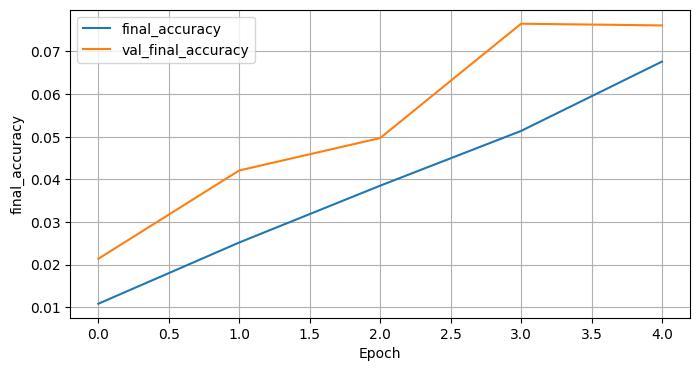

In [24]:
# Plot one main metric (final head accuracy) if available
def plot_metric(hist, key):
    if key not in hist.history:
        print("Key not found:", key)
        print("Available keys (sample):", list(hist.history.keys())[:20])
        return
    plt.figure(figsize=(8, 4))
    plt.plot(hist.history[key], label=key)
    val_key = "val_" + key
    if val_key in hist.history:
        plt.plot(hist.history[val_key], label=val_key)
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(history_v1, "final_accuracy")


In [25]:
results = model_v1.evaluate(test_gen_aux, steps=test_steps, verbose=1)
for name, value in zip(model_v1.metrics_names, results):
    print(f"{name:30s}: {value:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - aux1_accuracy: 0.0848 - aux1_loss: 4.3640 - aux2_accuracy: 0.0683 - aux2_loss: 4.4863 - final_accuracy: 0.0709 - final_loss: 4.4542 - loss: 13.3045
loss                          : 13.2644
compile_metrics               : 4.4414
final_loss                    : 4.3505
aux1_loss                     : 4.4727
aux2_loss                     : 0.0835


## 8) Toward minimalism: Minception (Inception-ResNet style)

The chapter introduces a more minimal Inception-style design that:
- uses parallel branches like Inception,
- uses residual-style connections,
- and has explicit reduction blocks.

I reproduce a compact version here to keep the code readable, while preserving the main ideas:
- **Block A** (Inception-ResNet style),
- **Block B**,
- **Reduction block**,
- global pooling + dropout + classifier.

This model has a single output head (simpler training loop), which is also convenient for Grad-CAM later.


In [26]:
from tensorflow.keras.layers import BatchNormalization, Activation, Add, GlobalAveragePooling2D

def conv_bn_relu(x, filters, k, s=1, p="same"):
    x = Conv2D(filters, k, strides=(s, s), padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def minception_stem(inp):
    x = conv_bn_relu(inp, 32, (3, 3), s=2, p="same")
    x = conv_bn_relu(x, 32, (3, 3), s=1, p="same")
    x = conv_bn_relu(x, 64, (3, 3), s=1, p="same")
    x = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)
    x = conv_bn_relu(x, 80, (1, 1), s=1, p="same")
    x = conv_bn_relu(x, 192, (3, 3), s=1, p="same")
    x = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)
    return x

def minception_block_a(x, scale=0.1):
    # Branch 1: 1x1
    b1 = conv_bn_relu(x, 32, (1, 1))

    # Branch 2: 1x1 -> 3x3
    b2 = conv_bn_relu(x, 32, (1, 1))
    b2 = conv_bn_relu(b2, 32, (3, 3))

    # Branch 3: 1x1 -> 3x3 -> 3x3
    b3 = conv_bn_relu(x, 32, (1, 1))
    b3 = conv_bn_relu(b3, 48, (3, 3))
    b3 = conv_bn_relu(b3, 64, (3, 3))

    mixed = Concatenate(axis=-1)([b1, b2, b3])
    up = Conv2D(K.int_shape(x)[-1], (1, 1), padding="same", use_bias=True)(mixed)

    x = Add()([x, up * scale])
    x = Activation("relu")(x)
    return x

def minception_block_b(x, scale=0.1):
    # Branch 1: 1x1
    b1 = conv_bn_relu(x, 64, (1, 1))

    # Branch 2: 1x1 -> 1x7 -> 7x1
    b2 = conv_bn_relu(x, 64, (1, 1))
    b2 = conv_bn_relu(b2, 64, (1, 7))
    b2 = conv_bn_relu(b2, 64, (7, 1))

    mixed = Concatenate(axis=-1)([b1, b2])
    up = Conv2D(K.int_shape(x)[-1], (1, 1), padding="same", use_bias=True)(mixed)

    x = Add()([x, up * scale])
    x = Activation("relu")(x)
    return x

def minception_reduction(x):
    # Reduction: downsample spatial resolution
    b1 = conv_bn_relu(x, 128, (3, 3), s=2, p="same")

    b2 = conv_bn_relu(x, 64, (1, 1))
    b2 = conv_bn_relu(b2, 64, (3, 3))
    b2 = conv_bn_relu(b2, 128, (3, 3), s=2, p="same")

    b3 = MaxPool2D((3, 3), strides=(2, 2), padding="same")(x)

    x = Concatenate(axis=-1)([b1, b2, b3])
    return x

def build_minception(input_shape=(64, 64, 3), n_classes=200):
    K.clear_session()
    inp = Input(shape=input_shape)
    x = minception_stem(inp)

    for _ in range(3):
        x = minception_block_a(x)

    x = minception_reduction(x)

    for _ in range(3):
        x = minception_block_b(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    out = Dense(n_classes, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

minception_model = build_minception()
minception_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        320 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        768 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 1,413,928 (5.39 MB)

 Trainable params: 1,409,384 (5.38 MB)

 Non-trainable params: 4,544 (17.75 KB)

### 8.1 Training Minception (single-output)

For Minception, the generators can return `(x, y)` directly.
I reuse the same directory-based pipeline, but I keep centering consistent.


In [27]:
def data_gen_centered(gen):
    while True:
        x, y = next(gen)
        x = x.astype(np.float32)
        x -= np.mean(x, axis=(1, 2, 3), keepdims=True)
        yield x, y

train_gen_centered = data_gen_centered(train_gen)
valid_gen_centered = data_gen_centered(valid_gen)
test_gen_centered  = data_gen_centered(test_gen)

EPOCHS_MIN = 5

history_min = minception_model.fit(
    train_gen_centered,
    validation_data=valid_gen_centered,
    epochs=EPOCHS_MIN,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    verbose=1,
)

min_results = minception_model.evaluate(test_gen_centered, steps=test_steps, verbose=1)
print("Test loss:", min_results[0])
print("Test acc :", min_results[1])


Epoch 1/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 187s 218ms/step - accuracy: 0.0326 - loss: 5.1052 - val_accuracy: 0.1003 - val_loss: 4.2977
Epoch 2/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 136s 193ms/step - accuracy: 0.1139 - loss: 4.1962 - val_accuracy: 0.1485 - val_loss: 3.8902
Epoch 3/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 134s 190ms/step - accuracy: 0.1667 - loss: 3.8108 - val_accuracy: 0.1988 - val_loss: 3.5690
Epoch 4/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 135s 191ms/step - accuracy: 0.2045 - loss: 3.5588 - val_accuracy: 0.2014 - val_loss: 3.6596
Epoch 5/5
704/704 ━━━━━━━━━━━━━━━━━━━━ 132s 188ms/step - accuracy: 0.2360 - loss: 3.3846 - val_accuracy: 0.2405 - val_loss: 3.4164
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2303 - loss: 3.4254
Test loss: 3.3972487449645996
Test acc : 0.23469999432563782


## 9) Transfer learning with a pretrained model

Training a large CNN from scratch on Tiny ImageNet can be slow, and it often needs careful tuning.
Transfer learning is a practical shortcut:

1) Start from a pretrained backbone (trained on ImageNet),
2) Attach a new head for 200 classes,
3) Train only the head first (freeze backbone),
4) Optionally unfreeze a small part for fine-tuning.

In the chapter, a pretrained **Inception-ResNet v2** is used, which expects **224×224** inputs.
So here I create a separate set of generators with `target_size=(224, 224)` and use the application-specific preprocessing.


In [28]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

BATCH_TL = 64
TARGET_TL = (224, 224)

image_gen_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
)

train_gen_tl = image_gen_tl.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=True,
    seed=SEED,
    subset="training",
)

valid_gen_tl = image_gen_tl.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=False,
    seed=SEED,
    subset="validation",
)

test_gen_tl = image_gen_tl.flow_from_dataframe(
    dataframe=test_df,
    directory=str(val_dir / "images"),
    x_col="filename",
    y_col="class",
    classes=class_list,
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=False,
)

steps_tl = int(np.ceil(train_gen_tl.samples / BATCH_TL))
val_steps_tl = int(np.ceil(valid_gen_tl.samples / BATCH_TL))
test_steps_tl = int(np.ceil(test_gen_tl.samples / BATCH_TL))

print("Transfer learning generators ready.")


Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Transfer learning generators ready.


In [29]:
def build_transfer_model(n_classes=200):
    K.clear_session()
    base = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="avg"
    )
    base.trainable = False  # freeze backbone first

    inp = Input(shape=(224, 224, 3))
    x = base(inp, training=False)
    x = Dropout(0.5)(x)
    out = Dense(n_classes, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model, base

tl_model, tl_base = build_transfer_model()
tl_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       307,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,644,136 (208.45 MB)

 Trainable params: 307,400 (1.17 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [30]:
EPOCHS_TL = 3  # head training

history_tl = tl_model.fit(
    train_gen_tl,
    validation_data=valid_gen_tl,
    epochs=EPOCHS_TL,
    steps_per_epoch=steps_tl,
    validation_steps=val_steps_tl,
    verbose=1,
)

tl_eval = tl_model.evaluate(test_gen_tl, steps=test_steps_tl, verbose=1)
print("Test loss:", tl_eval[0])
print("Test acc :", tl_eval[1])


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 501s 334ms/step - accuracy: 0.5272 - loss: 2.3439 - val_accuracy: 0.6970 - val_loss: 1.2844
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 440s 313ms/step - accuracy: 0.6829 - loss: 1.4045 - val_accuracy: 0.7025 - val_loss: 1.2968
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 441s 313ms/step - accuracy: 0.6939 - loss: 1.3462 - val_accuracy: 0.7041 - val_loss: 1.3185
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.7078 - loss: 1.3348
Test loss: 1.3121740818023682
Test acc : 0.7092999815940857


### 9.1 Optional fine-tuning

If you want to fine-tune, the typical workflow is:
- unfreeze a small top part of the backbone,
- lower the learning rate,
- train for a few more epochs.

I keep it optional because it increases compute time.


In [31]:
# Optional fine-tuning (comment out if you want to skip)
FINE_TUNE = False

if FINE_TUNE:
    # Unfreeze the top portion
    tl_base.trainable = True
    for layer in tl_base.layers[:-50]:
        layer.trainable = False

    tl_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history_ft = tl_model.fit(
        train_gen_tl,
        validation_data=valid_gen_tl,
        epochs=2,
        steps_per_epoch=steps_tl,
        validation_steps=val_steps_tl,
        verbose=1,
    )

    tl_eval2 = tl_model.evaluate(test_gen_tl, steps=test_steps_tl, verbose=1)
    print("Fine-tuned test acc:", tl_eval2[1])


## 10) Grad-CAM: Making the CNN confess

Grad-CAM produces a heatmap showing which regions of the image contribute most to a class prediction.

High-level steps:
1) pick a target convolution layer (typically close to the end),
2) compute gradients of the predicted class score w.r.t. that layer’s feature maps,
3) weight the feature maps by the averaged gradients (importance),
4) apply ReLU and resize to image size,
5) overlay on the original image.

I apply Grad-CAM on the transfer learning model because it has a clean single-output structure.


Last conv layer (heuristic): conv_7b


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


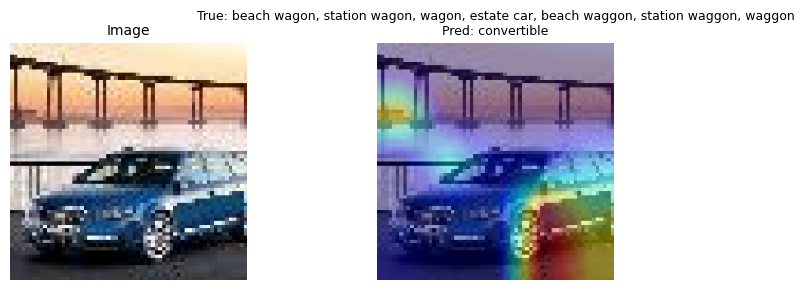

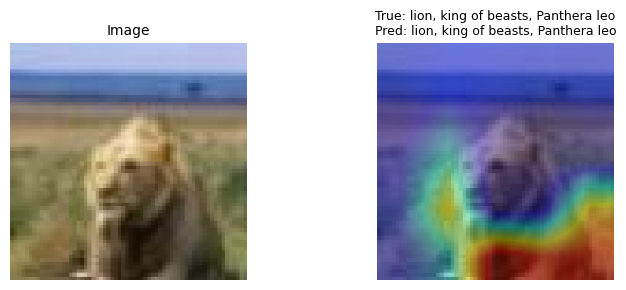

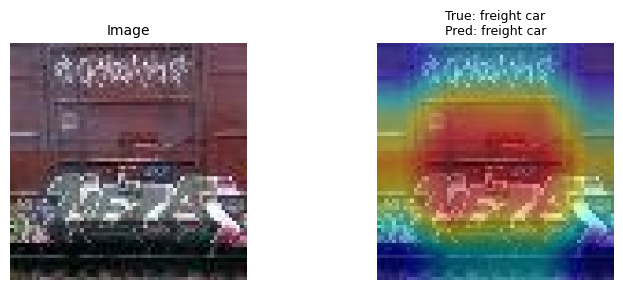

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_last_conv_layer_name(model):
    # choose the last Conv2D layer (simple heuristic)
    # If nested, search inside the nested model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        if isinstance(layer, tf.keras.Model):
            # If it's a model-inside-model (like InceptionResNetV2 as a layer)
            for sub in reversed(layer.layers):
                if isinstance(sub, tf.keras.layers.Conv2D):
                    return sub.name
    return None

last_conv_name = get_last_conv_layer_name(tl_model)
print("Last conv layer (heuristic):", last_conv_name)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Identify the base model (nested) and the head layers
    base_model = None
    head_layers = []
    found_base = False

    # Scan layers to find the nested backbone (e.g. InceptionResNetV2)
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            found_base = True
            continue
        if found_base:
            head_layers.append(layer)

    if base_model is None:
        # Standard case: layer is directly in model
        grad_model = tf.keras.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
        with tf.GradientTape() as tape:
            conv_out, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_score = preds[:, pred_index]
        grads = tape.gradient(class_score, conv_out)
    else:
        # Nested case: Extract conv output from base, then run head layers manually
        last_conv_layer = base_model.get_layer(last_conv_layer_name)

        # Model that outputs: [conv_out, base_output (pooled)]
        base_sub_model = tf.keras.Model(base_model.inputs, [last_conv_layer.output, base_model.output])

        with tf.GradientTape() as tape:
            # Run through the base to get features
            conv_out, base_out = base_sub_model(img_array)

            # Run through the rest of the head layers (Dropout, Dense, etc.)
            x = base_out
            for layer in head_layers:
                x = layer(x)
            preds = x

            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_score = preds[:, pred_index]

        grads = tape.gradient(class_score, conv_out)

    # 2. Process gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    # img is expected to be [0, 255] uint8 for color mapping
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return overlay

# Take a small batch from test_gen_tl and run Grad-CAM for a few images
try:
    x_batch, y_batch = next(iter(test_gen_tl))
    preds = tl_model.predict(x_batch, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_batch, axis=1)

    idx_to_wnid = {v: k for k, v in train_gen.class_indices.items()}
    wnid_to_desc = dict(zip(labels["wnid"], labels["class"]))

    def show_gradcam_examples(x_batch, true_labels, pred_labels, n=3):
        for i in range(n):
            img = x_batch[i].copy()
            # x_batch is preprocessed (e.g. InceptionResNetV2 uses [-1, 1]).
            # We rescale to [0, 255] for display.
            disp = img.copy()
            disp = (disp - disp.min()) / (disp.max() - disp.min() + 1e-8)
            disp = (disp * 255).astype(np.uint8)

            heatmap = make_gradcam_heatmap(x_batch[i:i+1], tl_model, last_conv_name, pred_index=pred_labels[i])
            overlay = overlay_heatmap_on_image(disp, heatmap)

            true_wnid = idx_to_wnid.get(true_labels[i], str(true_labels[i]))
            pred_wnid = idx_to_wnid.get(pred_labels[i], str(pred_labels[i]))
            true_desc = wnid_to_desc.get(true_wnid, true_wnid)
            pred_desc = wnid_to_desc.get(pred_wnid, pred_wnid)

            plt.figure(figsize=(8, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(disp)
            plt.axis("off")
            plt.title("Image", fontsize=10)

            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.axis("off")
            plt.title(f"True: {true_desc}\nPred: {pred_desc}", fontsize=9)
            plt.tight_layout()
            plt.show()

    show_gradcam_examples(x_batch, true_labels, pred_labels, n=3)
except Exception as e:
    print("An error occurred during Grad-CAM execution:", e)
    import traceback
    traceback.print_exc()

Last conv layer (heuristic): conv_7b


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


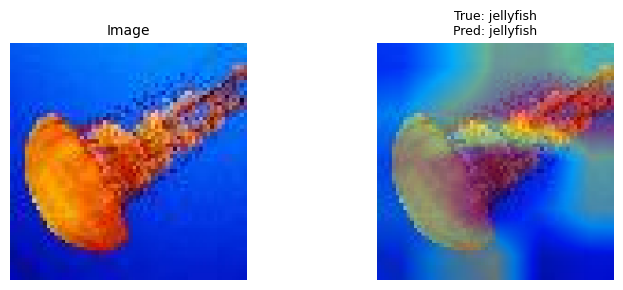

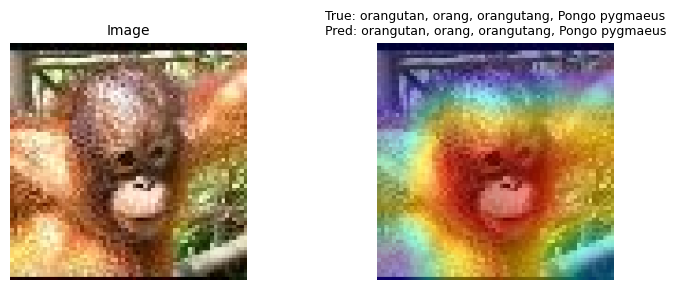

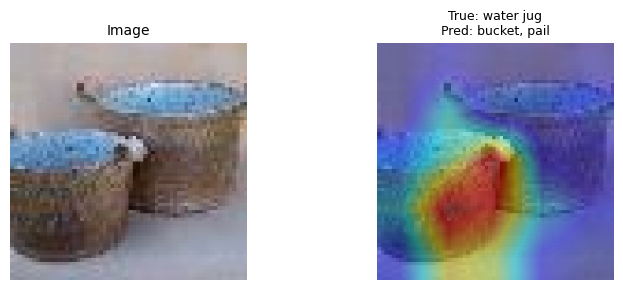

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def get_last_conv_layer_name(model):
    # Search for the last Conv2D layer
    # If nested, search inside the nested model
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
        if isinstance(layer, tf.keras.Model):
            # If it's a model-inside-model (like InceptionResNetV2)
            for sub in reversed(layer.layers):
                if isinstance(sub, tf.keras.layers.Conv2D):
                    return sub.name
    return None

last_conv_name = get_last_conv_layer_name(tl_model)
print("Last conv layer (heuristic):", last_conv_name)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # 1. Identify if we have a nested base model (like InceptionResNetV2)
    base_model = None
    head_layers = []
    found_base = False

    # Scan layers to find the nested backbone and subsequent head layers
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            base_model = layer
            found_base = True
            continue
        if found_base:
            head_layers.append(layer)

    if base_model is None:
        # Standard case: layer is directly in model (no nesting)
        grad_model = tf.keras.Model(
            inputs=model.inputs,
            outputs=[model.get_layer(last_conv_layer_name).output, model.output]
        )
        with tf.GradientTape() as tape:
            conv_out, preds = grad_model(img_array)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_score = preds[:, pred_index]
        grads = tape.gradient(class_score, conv_out)
    else:
        # Nested case: Extract conv output from base, then run head layers manually
        last_conv_layer = base_model.get_layer(last_conv_layer_name)

        # Create a sub-model of the backbone that outputs both the feature map and the pooled vector
        # base_model.output is likely the global average pooled vector (since pooling='avg' was set)
        base_sub_model = tf.keras.Model(
            inputs=base_model.inputs,
            outputs=[last_conv_layer.output, base_model.output]
        )

        with tf.GradientTape() as tape:
            # Run through the base to get features
            conv_out, base_out = base_sub_model(img_array)

            # Run through the rest of the head layers (Dropout, Dense, etc.)
            x = base_out
            for layer in head_layers:
                x = layer(x, training=False)
            preds = x

            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_score = preds[:, pred_index]

        grads = tape.gradient(class_score, conv_out)

    # 2. Process gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out = conv_out[0]

    # Weight the feature maps by the pooled gradients
    heatmap = tf.reduce_sum(conv_out * pooled_grads, axis=-1)

    # Apply ReLU
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    # img is expected to be [0, 255] uint8 for display
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (1 - alpha) * img + alpha * heatmap
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)
    return overlay

# --- Execution Block ---

# Take a small batch from test_gen_tl
try:
    x_batch, y_batch = next(iter(test_gen_tl))
    preds = tl_model.predict(x_batch, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    true_labels = np.argmax(y_batch, axis=1)

    idx_to_wnid = {v: k for k, v in train_gen.class_indices.items()}
    wnid_to_desc = dict(zip(labels["wnid"], labels["class"]))

    def show_gradcam_examples(x_batch, true_labels, pred_labels, n=3):
        for i in range(n):
            img = x_batch[i].copy()
            # x_batch is preprocessed (e.g. InceptionResNetV2 uses [-1, 1]).
            # We rescale to [0, 255] for display purposes.
            disp = img.copy()
            disp = (disp - disp.min()) / (disp.max() - disp.min() + 1e-8)
            disp = (disp * 255).astype(np.uint8)

            heatmap = make_gradcam_heatmap(x_batch[i:i+1], tl_model, last_conv_name, pred_index=pred_labels[i])
            overlay = overlay_heatmap_on_image(disp, heatmap)

            true_wnid = idx_to_wnid.get(true_labels[i], str(true_labels[i]))
            pred_wnid = idx_to_wnid.get(pred_labels[i], str(pred_labels[i]))
            true_desc = wnid_to_desc.get(true_wnid, true_wnid)
            pred_desc = wnid_to_desc.get(pred_wnid, pred_wnid)

            plt.figure(figsize=(8, 3))
            plt.subplot(1, 2, 1)
            plt.imshow(disp)
            plt.axis("off")
            plt.title("Image", fontsize=10)

            plt.subplot(1, 2, 2)
            plt.imshow(overlay)
            plt.axis("off")
            plt.title(f"True: {true_desc}\nPred: {pred_desc}", fontsize=9)
            plt.tight_layout()
            plt.show()

    show_gradcam_examples(x_batch, true_labels, pred_labels, n=3)
except Exception as e:
    print("An error occurred during Grad-CAM execution:", e)
    import traceback
    traceback.print_exc()

In [39]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

BATCH_TL = 64
TARGET_TL = (224, 224)

image_gen_tl = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,
)

train_gen_tl = image_gen_tl.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=True,
    seed=SEED,
    subset="training",
)

valid_gen_tl = image_gen_tl.flow_from_directory(
    directory=str(train_dir),
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=False,
    seed=SEED,
    subset="validation",
)

test_gen_tl = image_gen_tl.flow_from_dataframe(
    dataframe=test_df,
    directory=str(val_dir / "images"),
    x_col="filename",
    y_col="class",
    classes=class_list,
    target_size=TARGET_TL,
    class_mode="categorical",
    batch_size=BATCH_TL,
    shuffle=False,
)

steps_tl = int(np.ceil(train_gen_tl.samples / BATCH_TL))
val_steps_tl = int(np.ceil(valid_gen_tl.samples / BATCH_TL))
test_steps_tl = int(np.ceil(test_gen_tl.samples / BATCH_TL))

print("Transfer learning generators ready.")

Found 90000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Transfer learning generators ready.


In [40]:
def build_transfer_model(n_classes=200):
    K.clear_session()
    base = InceptionResNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="avg"
    )
    base.trainable = False  # freeze backbone first

    inp = Input(shape=(224, 224, 3))
    x = base(inp, training=False)
    x = Dropout(0.5)(x)
    out = Dense(n_classes, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model, base

tl_model, tl_base = build_transfer_model()
tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       307,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,644,136 (208.45 MB)

 Trainable params: 307,400 (1.17 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

## 11) Takeaways

- Overfitting becomes very visible on Tiny ImageNet because the dataset is larger, more diverse, and more fine-grained than toy datasets.
- Augmentation is not only about rotations and flips; custom augmentations such as gamma correction and random occlusion can target realistic variations.
- Dropout is most effective when applied to dense parts of the model (auxiliary heads and final head), where overfitting is more likely.
- A minimal Inception-style architecture can preserve multi-scale feature learning while simplifying the overall design.
- Transfer learning is a strong baseline: pretrained features often outperform training from scratch when compute and time are limited.
- Grad-CAM provides a practical interpretability tool that helps validate whether the model is looking at relevant regions or exploiting shortcuts.


## 12) References

- Thushan Ganegedara, *TensorFlow in Action* (Chapter 7).
- Keras documentation: `ImageDataGenerator`, pretrained applications (`InceptionResNetV2`).
- Grad-CAM: Selvaraju et al., “Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization.”
